Let's have a deeper look at acquisition functions...

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

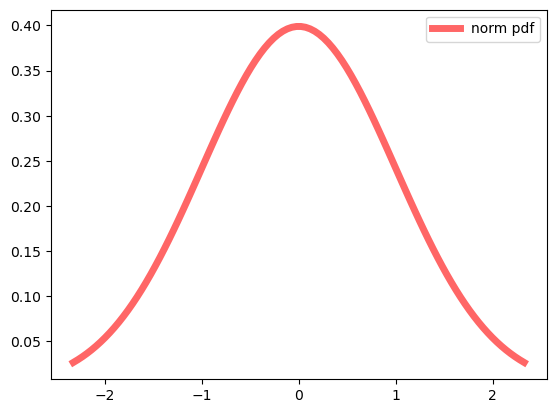

In [3]:
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')

#probability distribution function: pdf
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')
plt.legend()

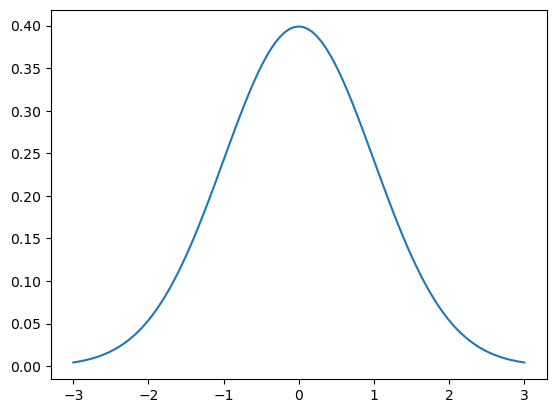

In [10]:
x = np.linspace(-3, 3, 101) #this is equivalent to norm.ppf(percentile)
y = norm.pdf(x)
plt.plot(x, y)


Before diving into the main topic.. let's set this plot into log scale..

(This looks irrelevant to the topic of this notebook but I believe it is important.. when we need to confirm a distribution is really a gaussian distribution or not.)

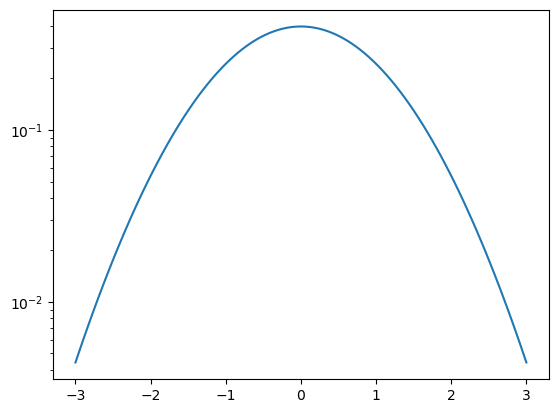

In [11]:
plt.semilogy(x, y) #this is expected as a hyperbola, semilog is the log only on y
# why this is a hyperbola?

Why this is a hyperbola?

If we take the original expression of gaussian distribution:

y = exp(-((x-mu)/sigma))^2)

we simplify the things in exp as one variable:

y = exp(-z^2)

Take log on y side, exp will be cancelled out, leaving -z^2 only.

qed

There is another distribution (Lorentzian) that looks similar to gaussian on the normal scale:

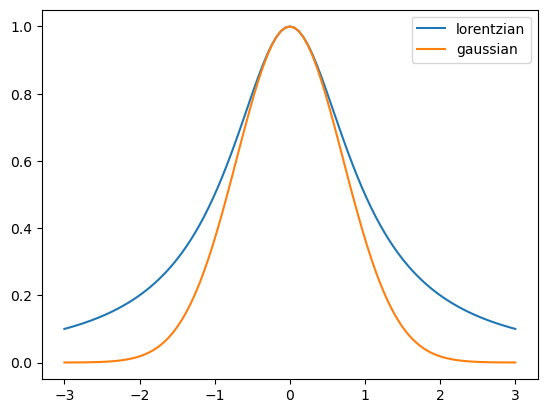

In [18]:
# In spectrum analysis, it's crucial to distinguish gaussian lineshape and lorentzian lineshape

l = 1/(1+x**2)

plt.plot(x, l, label = 'lorentzian')
plt.plot(x, np.exp(-x**2), label = 'gaussian')
plt.legend()

but if we take the log plot, they look different..

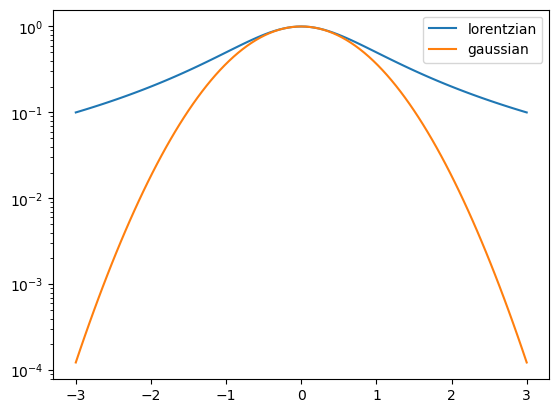

In [20]:
plt.plot(x, l, label = 'lorentzian')
plt.plot(x, np.exp(-x**2), label = 'gaussian')
plt.gca().set_yscale("log")
plt.legend()

The gaussian process is based on the assumption that the observable at a given point follows the gaussian distribution. 

Although it's hard to say is all current B.O. application papers emphasised/tested this assumption, we still stress this assumption is crucial to make sure all the further analysis is valid. 

Back onto gaussian distribution, there are two parameters: mean (mu) and std (sigma).

The famous 3-sigma rules say:

For a normal distribution, 68% of the population lies within 1 sigma; 95% -> 2 sigma; 99% -> 3 sigma

In [23]:
mean, var, skew, kurt = norm.stats(moments='mvsk')
print(mean, var, skew, kurt)

0.0 1.0 0.0 0.0


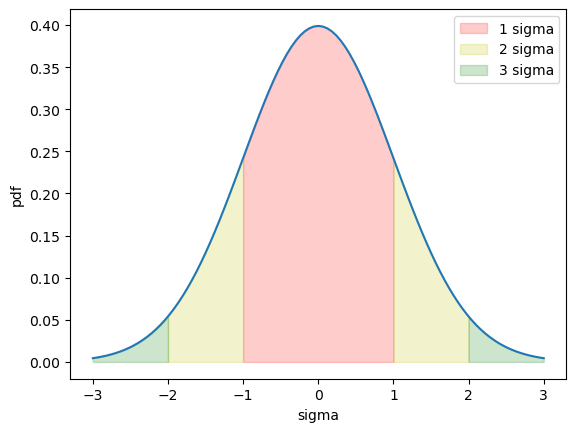

In [48]:
x = np.linspace(-3, 3, 101) #this is equivalent to norm.ppf(percentile)
y = norm.pdf(x)
plt.plot(x, y)

# to_fill_x = np.linspace(-1, 1, 41)
# to_fill_y = norm.pdf(to_fill_x)

#1sigma
plt.fill_between(np.linspace(-1,1), norm.pdf(np.linspace(-1,1)), color = 'r', alpha = 0.2, label = '1 sigma')

#2sigma

sigma_2_left = np.linspace(-2, -1)
sigma_2_right = np.linspace(1, 2)

# sigma_2_all = np.concatenate([sigma_2_left, sigma_2_right]) #this doesn't work....
sigma_2_y_left = norm.pdf(sigma_2_left)
sigma_2_y_right = norm.pdf(sigma_2_right)
plt.fill_between(sigma_2_left, sigma_2_y_left, color = 'y', alpha = 0.2, label = '2 sigma')
plt.fill_between(sigma_2_right, sigma_2_y_right, color = 'y', alpha = 0.2)

# plt.fill_between(np.linspace(-2,2), norm.pdf(np.linspace(-2,2)), color = 'y', alpha = 0.2, label = '2 sigma')

#3sigma
# plt.fill_between(np.linspace(-3,3), norm.pdf(np.linspace(-3,3)), color = 'g', alpha = 0.2, label = '3 sigma')
sigma_3_left = np.linspace(-3, -2)
sigma_3_right = np.linspace(2, 3)

sigma_3_y_left = norm.pdf(sigma_3_left)
sigma_3_y_right = norm.pdf(sigma_3_right)
plt.fill_between(sigma_3_left, sigma_3_y_left, color = 'g', alpha = 0.2, label = '3 sigma')
plt.fill_between(sigma_3_right, sigma_3_y_right, color = 'g', alpha = 0.2)

plt.xlabel("sigma")
plt.ylabel("pdf")

plt.legend()

Now we look at which region reflect 95% confidence interval.

95% confidence interval means 95% of the population belongs to this region.

we can use ```ppf``` function (percent point function) to workout the threshold of corresponding sigma


In [50]:
#let's look at which region reflect 95% confidence interval

#(1-0.95)/2
#left end
left_95ci_end = norm.ppf(0.025)
print(left_95ci_end)

#1-(1-0.95)/2
#right end
right_95ci_end = norm.ppf(0.975)
print(right_95ci_end)


-1.9599639845400545
1.959963984540054


## Upper confidence bound (UCB)

$f = \mu + \kappa \sigma$

where $\mu$, $\sigma$ is the mean and std of gaussian distribution, 

$\kappa$ reflects the coefficient of std (or the contribution of std).

- $\kappa$ equals 0 means only $\mu$ is considered.
- $\kappa$ equals 1.96 means the predicition is based on 97.5% confidence interval (it takes the upper limit and only consider single side), i.e., ppf for 0.975 percentile. There's only 2.5% chance that the real situation is beyond this prediction. 

In [54]:
#not believe?
#try:
norm.ppf(0.975)
#your kappa shoule be:

1.959963984540054

In [55]:
# another example: if you want 5% real situation beyond your prediction
norm.ppf(0.95)
#then your kappa needs to be:

1.6448536269514722

So, in terms of optimisation, this magic $\kappa$ depends on

- whether you want to explore the vast region where global optimial could be located, but not yet captured by current data (larger $\kappa$),
- or, stick to the largest optimal (not necessarily to be global) that has been indicated by your current data (smaller $\kappa$).

ucb predicted best next x to go: ucb_x=1.8.


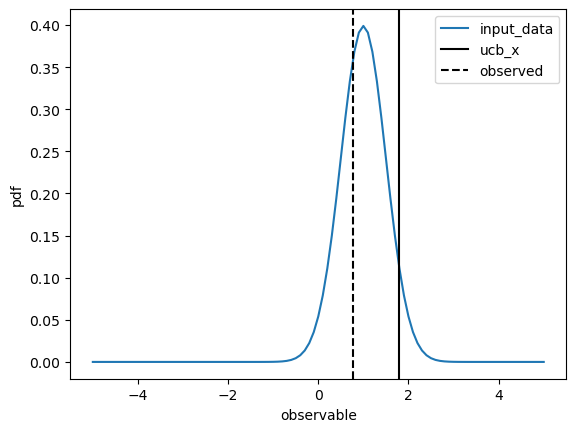

In [99]:
# ucb only has one parameter (kappa) to be specified by user

ucb_param = {
    'kappa' : 1.6
}

def ucb(kappa, gpr_mean, gpr_std):

    ucb_x = gpr_mean + kappa*gpr_std
    print(f"ucb predicted best next x to go: {ucb_x=}.")
    return ucb_x

# suppose the mean and std obtained by gaussian process is mu and sigma
gpr_res = {
    'mu' : 1,
    'sigma' : 0.5
}

#to visualise the result, we define the visualise window as -5 to 5 (normall referred as pbound in BO):
x = np.linspace(-5, 5, 101)

#calculate the gaussian distribution of x

mu = gpr_res['mu']
sigma = gpr_res['sigma']

#first standardise the initial input as a normal distribution (we can use zscore directly but here we make it clearer...)
z = (x-mu)/sigma
y = norm.pdf(z)
# y = np.exp(-z**2) # this is the same thing as the last line


#workout the ucb result
ucb_x = ucb(ucb_param['kappa'], mu, sigma)

#assume gpr gives a reasonable result. This random number would be a good representation of what you would get in one observation:
real = np.random.normal(gpr_res['mu'], gpr_res['sigma'])

def check_for_result(pred, real):
    if pred >= real:
        print("Observed smaller than predicted, well done!")
    else:
        print("Observed larger than predicted. That's not happening very often!")

if ucb_param['kappa'] >= 1.9:
    check_for_result(ucb_x, real)

plt.plot(x, y, label = 'input_data')
plt.axvline(ucb_x, color = 'k', ls = '-', label = 'ucb_x')
plt.axvline(real, color = 'k', ls = '--', label = 'observed')
plt.ylabel('pdf')
plt.xlabel('observable')
plt.legend()


# Probability of improvement (POI)

Still based on the gaussian distribution, which is the distribution of our observable space.

If the current maximum sample value is ```obs_max```, the probability of improvement function equals the integral of current ```obs_max``` to the upper bound of observable space, plus a perturbation ```xi```.

Note that poi is based on accumulated probability, so we need to use ```cdf``` instead of ```pdf```.

For example, if current maximal of everything in the dataset is 1, whereas this point where POI is evaluating follows a (mu = 1, sigma = 0.5) gaussian distribution. 
If we select this point as the next point to go, it might be possible (could be ca. 50% chance) that the obserbation at this point gives a larger value than 2. (Try to modify the ```obs_max``` in ```poi_param``` as 1 and remain others the same, see the output.)

However, if the current maximal of everything in the dataset is 0, our POI for a potential next point with (mu = 1, sigma = 0.5) gaussian distribution would be very likley better (higher) than the current maximal. (I would bet that is a nearly 100% chance!)

Similarly, if ```obs_max``` is 2, I bet there's nearly 0% chance our current point can make any improvement.

The probability that using this point would improve the current maximal is: 0.02169169376764678
The black solid line is the position of 1 minus POI result. 


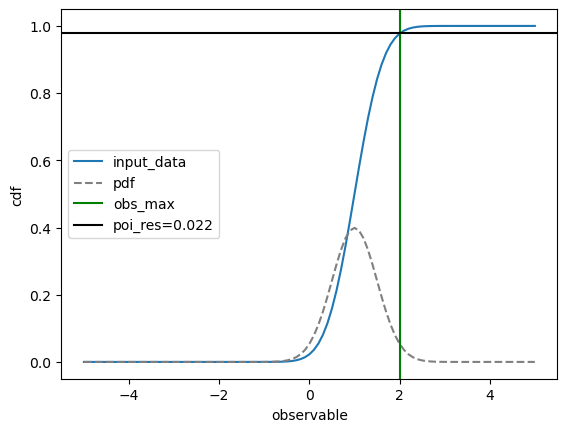

In [127]:
#parameters for poi

poi_param = {
    'obs_max' : 2,
    'xi' : 1e-2,
}

def poi(poi_param, gpr_res):
    gpr_mean = gpr_res['mu']
    gpr_std = gpr_res['sigma']
    obs_max = poi_param['obs_max']
    xi = poi_param['xi']

    poi_res = norm.cdf((gpr_mean - obs_max - xi)/gpr_std)

    return poi_res


# suppose the mean and std obtained by gaussian process is mu and sigma
gpr_res = {
    'mu' : 1,
    'sigma' : 0.5
}

#to visualise the result, we define the visualise window as -5 to 5 (normall referred as pbound in BO):
x = np.linspace(-5, 5, 101)

#calculate the gaussian distribution of x

mu = gpr_res['mu']
sigma = gpr_res['sigma']

#first standardise the initial input as a normal distribution (we can use zscore directly but here we make it clearer...)
z = (x-mu)/sigma
y = norm.cdf(z) #note that poi is based on accumulated probability, so cdf rather than pdf now
y_pdf = norm.pdf(z)
# y = np.exp(-z**2) # this is the same thing as the last line

# #assume gpr gives a reasonable result. This random number would be a good representation of what you would get in one observation:
# real = np.random.normal(gpr_res['mu'], gpr_res['sigma'])

#poi result
poi_res = poi(poi_param, gpr_res)

plt.plot(x, y, label = 'input_data_cdf')
# plt.axvline(poi_res, color = 'k', ls = '-', label = 'poi_res')
plt.plot(x, y_pdf, color = 'gray', ls = '--', label = 'pdf')
plt.axvline(poi_param['obs_max'], color = 'g', ls = '-', label = 'obs_max')

#result for poi: is a probability rather than observable
plt.axhline(1-poi_res, color = 'k', ls = '-', label = f'{poi_res=:.3f}')


plt.ylabel('cdf')
plt.xlabel('observable')
plt.legend()

print(f"The probability that using this point would improve the current maximal is: {poi_res}")
print("The black solid line is the position of 1 minus POI result. ")

obs_max: -5
probability of improvement: 1.0
obs_max: -4
probability of improvement: 1.0
obs_max: -3
probability of improvement: 0.9999999999999992
obs_max: -2
probability of improvement: 0.9999999988843119
obs_max: -1
probability of improvement: 0.999965542365885
obs_max: 0
probability of improvement: 0.9761482356584915
obs_max: 1
probability of improvement: 0.492021686283098
obs_max: 2
probability of improvement: 0.02169169376764678
obs_max: 3
probability of improvement: 2.909907071193099e-05
obs_max: 4
probability of improvement: 8.720853539929707e-10


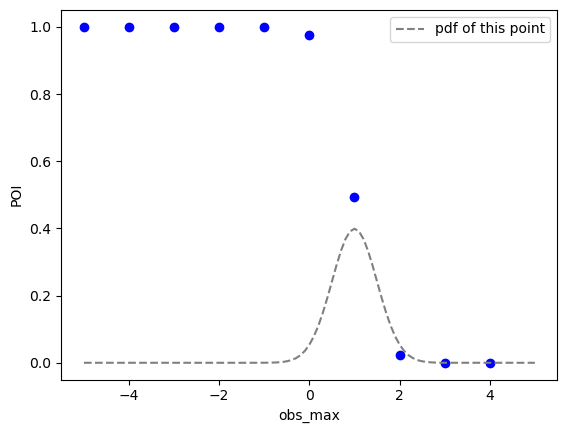

In [140]:
#test: For the same gaussian distribution, different obs_max

plt.plot(x, y_pdf, color = 'gray', ls = '--', label = 'pdf of this point')
for obs_max in range(-5, 5):
    poi_param = {
        'obs_max' : obs_max,
        'xi' : 1e-2,
    }
    poi_res = poi(poi_param, gpr_res)
    plt.scatter(obs_max, poi_res, color = 'b')
    plt.xlabel('obs_max')
    plt.ylabel('POI')
    
    print(f"obs_max: {poi_param['obs_max']:}")
    print(f"probability of improvement: {poi_res}")

plt.legend()

## Expected Improvement (EI)

Similar to POI but different..

Clarify all the variables:

- ```x```: this point, follows a normal distribution  ($\mu$, $\sigma$)
- ```x_max```: current maximal observed value so far, labelled as ```obs_max``` in the code.
- ```z```: the reparameterised ```x```, equals $(x-\mu)/\sigma$, i.e., the standardised normal distribution. 
- $\phi$ is the pdf of standard normal distribution

EI calculated the expectation of improvement:

## $\int_{x_{max}}^{\infty} (x - x_{max}) \phi(z)\, dx$


Apart from ```obs_max```, EI also has a perturbation term ```xi```.

After a few steps we can have:

## $(\mu - x_{max} - xi)$ * cdf($\frac{\mu-x_{max}-xi}{\sigma}$) + $\sigma$ * pdf($\mu - x_{max} - xi$) 

The expectation of using this point would improve the current maximal is: 0.1945409500302101
The black solid line is the position of 1 minus EI result. 


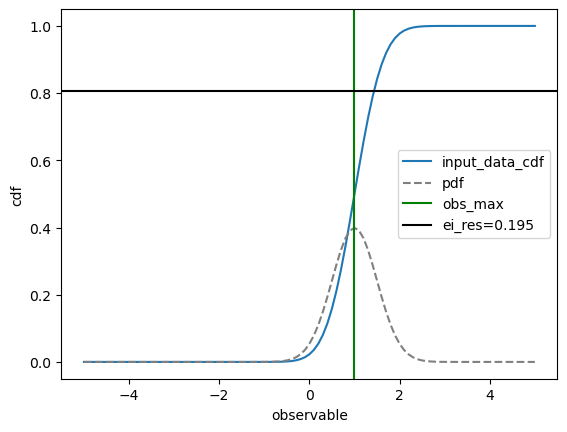

In [146]:
#parameters for ei

ei_param = {
    'obs_max' : 1,
    'xi' : 1e-2,
}

def ei(poi_param, gpr_res):
    gpr_mean = gpr_res['mu']
    gpr_std = gpr_res['sigma']
    obs_max = ei_param['obs_max']
    xi = ei_param['xi']

    ei_res = (gpr_mean - obs_max - xi) * norm.cdf((gpr_mean - obs_max - xi)/gpr_std) + gpr_std * norm.pdf((gpr_mean - obs_max - xi))

    return ei_res


# suppose the mean and std obtained by gaussian process is mu and sigma
gpr_res = {
    'mu' : 1,
    'sigma' : 0.5
}

#to visualise the result, we define the visualise window as -5 to 5 (normall referred as pbound in BO):
x = np.linspace(-5, 5, 101)

#calculate the gaussian distribution of x

mu = gpr_res['mu']
sigma = gpr_res['sigma']

#first standardise the initial input as a normal distribution (we can use zscore directly but here we make it clearer...)
z = (x-mu)/sigma
y = norm.cdf(z) 
y_pdf = norm.pdf(z)
# y = np.exp(-z**2) # this is the same thing as the last line

#ei result
ei_res = ei(ei_param, gpr_res)

plt.plot(x, y, label = 'input_data_cdf')
plt.plot(x, y_pdf, color = 'gray', ls = '--', label = 'pdf')
plt.axvline(ei_param['obs_max'], color = 'g', ls = '-', label = 'obs_max')

#result for poi: is a probability rather than observable
plt.axhline(1-ei_res, color = 'k', ls = '-', label = f'{ei_res=:.3f}')


plt.ylabel('cdf')
plt.xlabel('observable')
plt.legend()

print(f"The expectation of using this point would improve the current maximal is: {ei_res}")
print("The black solid line is the position of 1 minus EI result. ")

now we enveolop everything together:

In [64]:
def get_acq(coeff=0., acq_type='ucb'):
    def _ucb(gpr):
        mu = gpr['mu']
        sigma = gpr['sigma']
        #in ucb, coeff is kappa
        return mu + coeff*sigma
        
    def _ei(gpr):
        mu = gpr['mu']
        sigma = gpr['sigma']
        
        return

    def _poi(gpr):
        ymax = gpr['ymax']
        mu = gpr['mu']
        sigma = gpr['sigma']
        zmax = (ymax-mu)/sigma
        return 1 - norm.ppf(zmax)

    if acq_type.lower() == 'ucb': return _ucb
    if acq_type.lower() == 'ei': return _ei
    if acq_type.lower() == 'poi': return _poi
    raise ValueError("Unsupported acq_type. Please choose from 'ucb', 'ei', 'poi'.")

In [65]:
gpr_res = {
    'mu' : 1.2,
    'sigma' : 0.5
}

acq = get_acq(coeff=0.1, acq_type='ucb')
acq(gpr_res)

1.25